In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, multivariate_t, chi2
import DyGraph as dg
from sklearn.preprocessing import StandardScaler
import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import requests
import geopandas as gpd

Functions

In [2]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t( X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def log_lik_all(w, thetas, X, lik_type, nus, gammas = None):

    if gammas is None:
        gammas = [None] * len(thetas)

    lik_tmp = []
    for j in range(len(thetas)):
        lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X[j*w:(j+1)*w], liktype = lik_type, prec =thetas[j],  nu = nus[j], gamma = gammas[j]))

    return np.array(lik_tmp)
            
def nr_params(thetas, lik_type):
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<1e-2] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
        elif lik_type == 'group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]))
        elif lik_type == 'skew-group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
        else:
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

    return np.array(nr_params_tmp)




Load data

In [135]:
with open(f'../data/AQI/cleaned_aqi.pkl', 'rb') as handle:
    ts_df = pickle.load(handle)

scaler = StandardScaler()
ts_df_scaled = scaler.fit_transform(ts_df)
ts_df_scaled = ts_df_scaled[:2700]

In [136]:
df  = []

for y in range(2014,2023):
    d_tmp = pd.read_csv(f"../data/AQI/daily_aqi_by_county_{y}.csv")
    d_tmp = d_tmp.loc[d_tmp['State Name'] == 'California']
    d_tmp = d_tmp[['county Name', 'Date', 'AQI']].pivot(index = 'Date', columns='county Name', values='AQI')
    df.append(d_tmp)

df = pd.concat(df)
df_t = df.ffill().copy()
df_t = df_t.dropna(axis=1)
df_t = df_t.iloc[200:3000]
print(df_t.index[0])
print(df_t.index[-1])

2014-07-20
2022-03-19


Load spatial

In [4]:
wikiurl="https://en.wikipedia.org/wiki/User:Michael_J/County_table"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
sites = pd.read_html(response.content)[-1]
sites = sites.loc[(sites['State'] == 'CA') & np.isin(sites['County [2]'], ts_df.columns)]
sites['Latitude'] = sites['Latitude'].str.replace('°','')
sites['Latitude'] = sites['Latitude'].str.replace('+','')
sites['Latitude'] = sites['Latitude'].str.replace('–','')
sites['Latitude'] = sites['Latitude'].astype(float)
sites['Longitude'] = sites['Longitude'].str.replace('°','')
sites['Longitude'] = sites['Longitude'].str.replace('+','')
sites['Longitude'] = sites['Longitude'].str.replace('–','')
sites['Longitude'] = sites['Longitude'].astype(float)

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

   
locs = np.array(sites[['Latitude', 'Longitude']])
d = locs.shape[0]
R = np.zeros((d, d))

for i in range(d):
   for j in range(d):
      R[i,j] = distance(locs[i], locs[j])



G_geo = nx.from_numpy_array(R)
pos_spatial = {i:locs[i] for i in range(len(locs))}

In [5]:
print(np.round(R/np.max(R)*7,2))

[[0.   0.87 1.38 ... 1.08 2.71 0.7 ]
 [0.87 0.   0.97 ... 0.47 2.91 0.68]
 [1.38 0.97 0.   ... 1.42 3.86 0.69]
 ...
 [1.08 0.47 1.42 ... 0.   2.54 1.13]
 [2.71 2.91 3.86 ... 2.54 0.   3.31]
 [0.7  0.68 0.69 ... 1.13 3.31 0.  ]]


In [111]:
AQI_dict_g_spatial['alphas'][1]

0.0

In [95]:
dygl_aqi = dg.dygl_inner_em(X = ts_df_scaled[:2700], obs_per_graph=30, max_iter=10000, lamda= 7*R/np.max(R), kappa=0.05, lik_type='gaussian', tol = 1e-2)
dygl_aqi.fit(temporal_penalty='element-wise', nr_workers=1, verbose=True)

Error 3.85E+0:   0%|          | 9/10000 [00:06<53:28,  3.11it/s]  

KeyboardInterrupt: 

In [94]:
R/np.max(R)

array([[0.        , 0.12375227, 0.19783174, ..., 0.1541384 , 0.38780942,
        0.10037415],
       [0.12375227, 0.        , 0.13889435, ..., 0.06681506, 0.4150436 ,
        0.09781468],
       [0.19783174, 0.13889435, 0.        , ..., 0.2025436 , 0.55099972,
        0.09869367],
       ...,
       [0.1541384 , 0.06681506, 0.2025436 , ..., 0.        , 0.36244187,
        0.16122482],
       [0.38780942, 0.4150436 , 0.55099972, ..., 0.36244187, 0.        ,
        0.47301673],
       [0.10037415, 0.09781468, 0.09869367, ..., 0.16122482, 0.47301673,
        0.        ]])

In [53]:
print(np.round(dygl_aqi.theta[0],2))

[[ 0.88 -0.    0.   ... -0.   -0.    0.  ]
 [-0.    0.82  0.   ... -0.   -0.   -0.  ]
 [ 0.    0.    4.72 ...  0.   -0.   -0.  ]
 ...
 [-0.   -0.    0.   ...  0.79 -0.   -0.  ]
 [-0.   -0.   -0.   ... -0.    2.26 -0.  ]
 [ 0.   -0.   -0.   ... -0.   -0.    1.62]]


In [23]:
print(np.round(dygl_aqi.theta[0],2))

[[ 3.69  0.35 -0.26 ... -0.76 -0.16 -0.75]
 [ 0.35  2.11 -0.6  ... -0.43 -0.1   0.21]
 [-0.26 -0.6   9.34 ...  0.26 -0.05 -1.31]
 ...
 [-0.76 -0.43  0.26 ...  2.72 -0.14  0.1 ]
 [-0.16 -0.1  -0.05 ... -0.14  3.98  0.73]
 [-0.75  0.21 -1.31 ...  0.1   0.73  5.5 ]]


In [35]:
print(np.round(AQI_dict_g_spatial['thetas'][3][0][3],2))

[[ 3.93 -0.   -0.31 ...  0.16  0.01  0.03]
 [-0.    3.01 -0.61 ... -1.19 -0.11 -0.34]
 [-0.31 -0.61  2.43 ...  0.26  0.05  0.14]
 ...
 [ 0.16 -1.19  0.26 ...  4.15 -0.13 -0.1 ]
 [ 0.01 -0.11  0.05 ... -0.13  3.26 -0.08]
 [ 0.03 -0.34  0.14 ... -0.1  -0.08  2.17]]


In [124]:
with open(f'../data/AQI/AQI_t_model_ew.pkl', 'rb') as handle:
    AQI_dict_t = pickle.load(handle)

with open(f'../data/AQI/AQI_t_model_ew_with_spatial2.pkl', 'rb') as handle:
    AQI_dict_t_spatial = pickle.load(handle)

with open(f'../data/AQI/AQI_gaussian_model_ew.pkl', 'rb') as handle:
    AQI_dict_g = pickle.load(handle)

with open(f'../data/AQI/AQI_gaussian_model_ew_with_spatial2.pkl', 'rb') as handle:
    AQI_dict_g_spatial = pickle.load(handle)


In [117]:
AQI_dict_g_spatial['thetas'][0][3][0]

array([[ 4.46999415,  0.40811991, -0.17578544, ..., -0.99542118,
        -0.45287173, -0.9677326 ],
       [ 0.40811991,  2.41504138, -0.72780892, ..., -0.47404983,
        -0.02173068,  0.42345333],
       [-0.17578544, -0.72780892, 11.80626431, ...,  0.5610967 ,
        -0.15382349, -1.66775315],
       ...,
       [-0.99542118, -0.47404983,  0.5610967 , ...,  3.35940741,
        -0.08538514,  0.13247841],
       [-0.45287173, -0.02173068, -0.15382349, ..., -0.08538514,
         4.60559194,  1.14583529],
       [-0.9677326 ,  0.42345333, -1.66775315, ...,  0.13247841,
         1.14583529,  6.87806712]])

In [93]:
print(np.round(AQI_dict_g_spatial['thetas'][3][31][0],2))

[[ 1.36  0.   -0.   ... -0.26 -0.   -0.07]
 [ 0.    1.06 -0.01 ... -0.19 -0.   -0.  ]
 [-0.   -0.01  4.61 ... -0.   -0.   -0.  ]
 ...
 [-0.26 -0.19 -0.   ...  0.98 -0.   -0.02]
 [-0.   -0.   -0.   ... -0.    2.16 -0.  ]
 [-0.07 -0.   -0.   ... -0.02 -0.    2.19]]


In [7]:
print(AQI_dict_t['kappas'])
print(AQI_dict_t['alphas'])

[0.03019738 0.03536243 0.04141093 0.04849397 0.05678852 0.0665018
 0.07787646 0.09119667 0.10679522 0.12506179 0.14645272 0.17150242
 0.2008367  0.23518839 0.2754157  0.32252361 0.37768899 0.44229001
 0.51794059 0.60653066]
[0.00673795 0.0085386  0.01082047 0.01371214 0.01737659 0.02202032
 0.02790506 0.03536243 0.04481272 0.05678852 0.07196474 0.09119667
 0.11556817 0.14645272 0.18559089 0.23518839 0.29804037 0.37768899
 0.47862297 0.60653066]


Plot some edges

1740


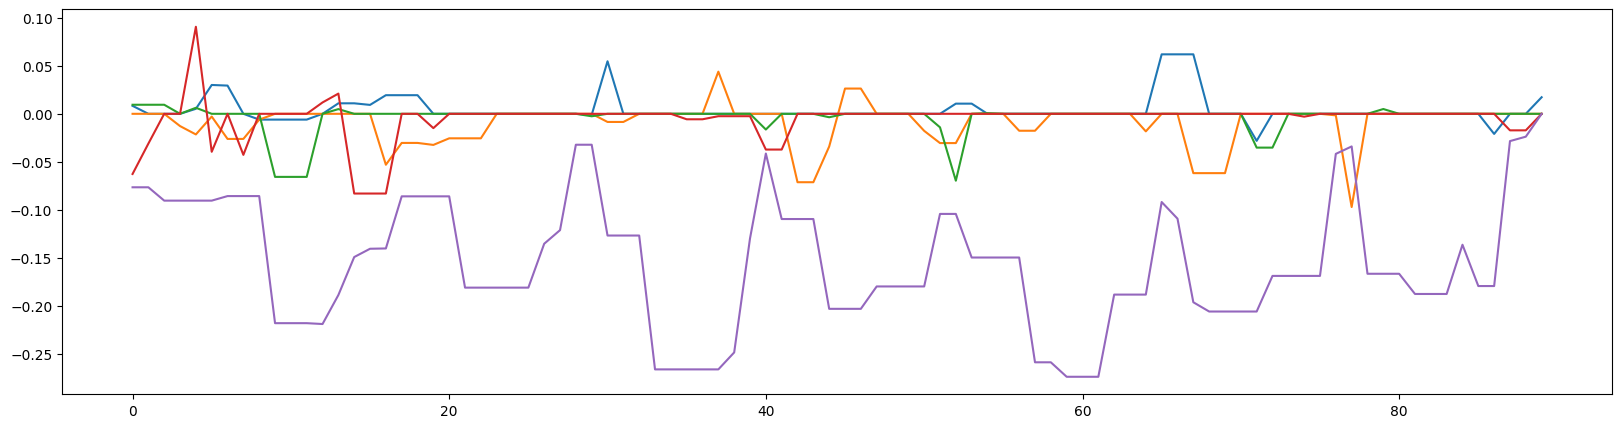

In [8]:
k_index = 11
a_index = 14

print(np.sum(np.abs(AQI_dict_t['thetas'][k_index][a_index][0] )< 1e-2))

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,1])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,2])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,3])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,4])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,5])

Find optimal using AIC

In [12]:
AQI_dict_t['alphas']

array([0.00673795, 0.0085386 , 0.01082047, 0.01371214, 0.01737659,
       0.02202032, 0.02790506, 0.03536243, 0.04481272, 0.05678852,
       0.07196474, 0.09119667, 0.11556817, 0.14645272, 0.18559089,
       0.23518839, 0.29804037, 0.37768899, 0.47862297, 0.60653066])

In [74]:
def find_aic(AQI_dict, ts_df_scaled, model):

    AICs = np.zeros((len(AQI_dict['kappas']), len(AQI_dict['alphas'])))

    pbar = tqdm.tqdm(total = np.prod(AICs.shape))

    for k_cnt, kappa in enumerate(AQI_dict['kappas']):
        for a_cnt, alpha in enumerate(AQI_dict['alphas']):
            pbar.update()
            try:
                thetas = AQI_dict['thetas'][k_cnt][a_cnt]
                nus =  AQI_dict['nus'][k_cnt][a_cnt]
                liks = log_lik_all(AQI_dict['obs_per_graph'], thetas, ts_df_scaled, AQI_dict['lik_type'], nus, gammas = None)
                nr_params_val = nr_params(thetas, model)
                AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))
            except:
                AICs[k_cnt, a_cnt] = np.nan
                continue

    pbar.close()

    return AICs


      

In [125]:
AIC_t = find_aic(AQI_dict_t, ts_df_scaled, 't')
AIC_g = find_aic(AQI_dict_g, ts_df_scaled, 'gaussian')
AIC_t_spat = find_aic(AQI_dict_t_spatial, ts_df_scaled, 't')
AIC_g_spat = find_aic(AQI_dict_g_spatial, ts_df_scaled, 'gaussian')

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


In [41]:
AIC_t_spat[0]

array([378803.4994946 , 378803.4994946 , 378803.4994946 , 378803.4994946 ,
       378803.4994946 , 378803.4994946 , 378803.4994946 , 378803.4994946 ,
       378803.4994946 , 378803.4994946 , 378803.4994946 , 378803.4994946 ,
       378803.4994946 , 378803.4994946 , 378803.4994946 , 378803.4994946 ,
       378803.4994946 , 378803.4994946 , 378803.4994946 , 378803.4994946 ,
       378803.4994946 , 378803.4994946 , 378803.4994946 , 378803.4994946 ,
       306786.22016933, 306786.22016933, 306786.22016933, 306786.22016933,
       306786.22016933, 306786.22016933, 306786.22016933, 304294.0600733 ,
       304294.0600733 , 306606.6091335 , 306606.6091335 , 309984.11464253,
       309984.11464253, 313458.55140744, 316878.08431077, 325370.99242586])

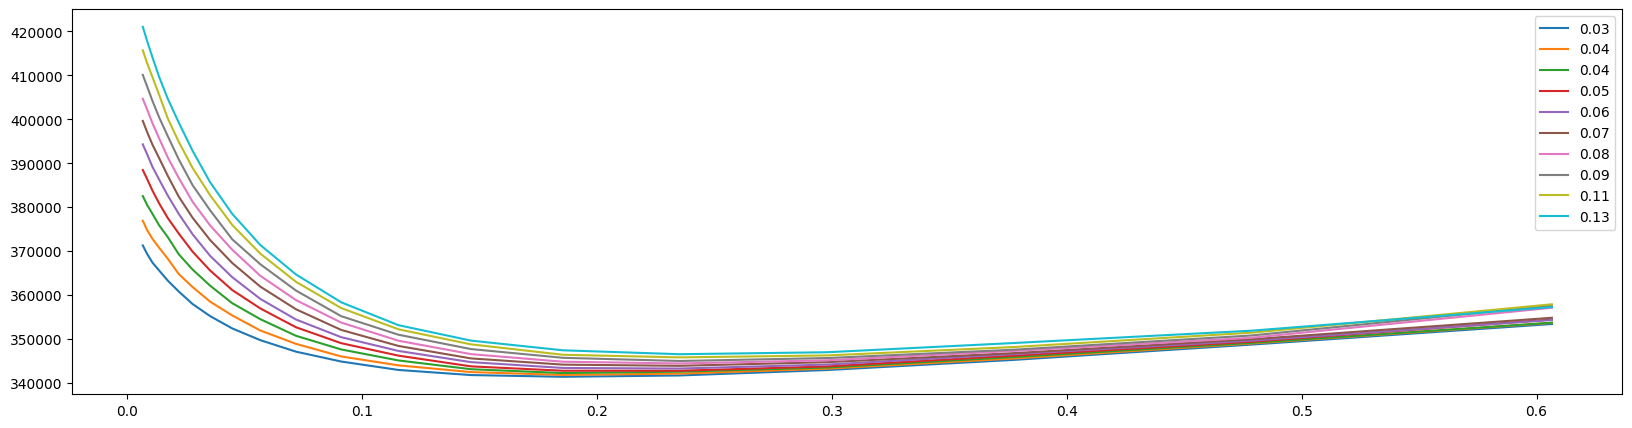

In [120]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(10):
    ax.plot(AQI_dict_t['alphas'], AIC_t[i], label = np.round(AQI_dict_t['kappas'][i],2))
ax.legend()
    

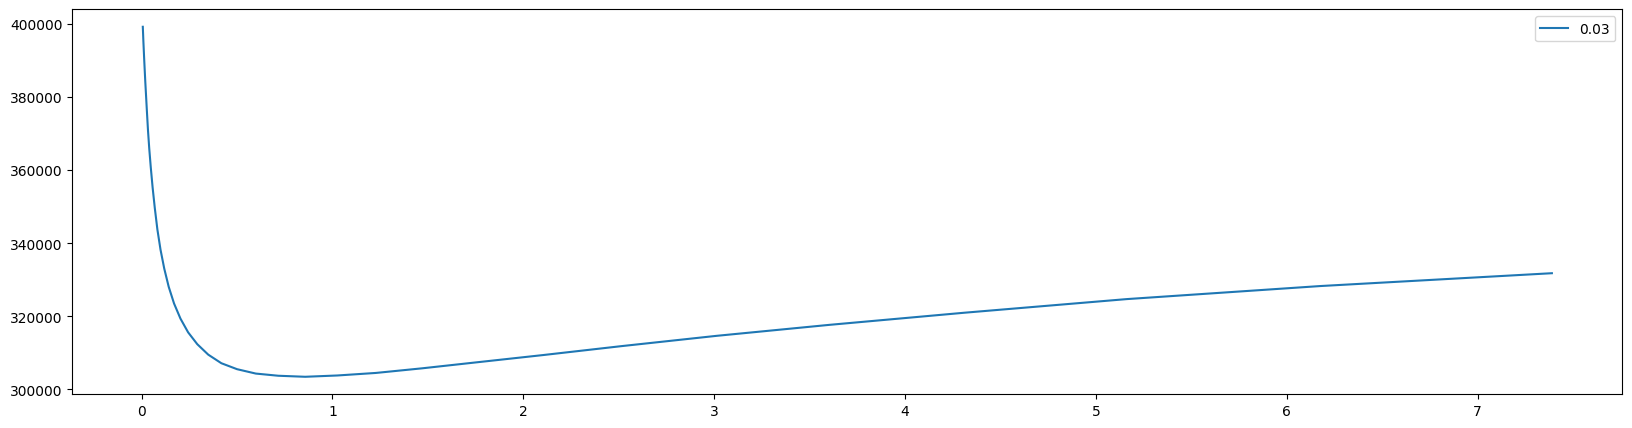

In [122]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(1):
    ax.plot(AQI_dict_g_spatial['alphas'], AIC_g_spat[i], label = np.round(AQI_dict_g_spatial['kappas'][i],2))
ax.legend()

In [57]:
 AIC_t_spat[3]

array([412155.3717174 , 412155.3717174 , 412155.3717174 , 412155.3717174 ,
       412155.3717174 , 412155.3717174 , 412155.3717174 , 412155.3717174 ,
       412155.3717174 , 412155.3717174 , 412155.3717174 , 412155.3717174 ,
       412155.3717174 , 412155.3717174 , 412155.3717174 , 412155.3717174 ,
       412155.3717174 , 412155.3717174 , 412155.3717174 , 412155.3717174 ,
       412155.3717174 , 412155.3717174 , 412155.3717174 , 412155.3717174 ,
       312452.85224574, 312452.85224574, 312452.85224574, 312452.85224574,
       312452.85224574, 312452.85224574, 312452.85224574, 309053.90071064,
       309053.90071064, 310993.33568128, 310993.33568128, 313670.83035959,
       313670.83035959, 317817.99128243, 326054.11570177, 329444.90728224])

(0.0, 3.7)

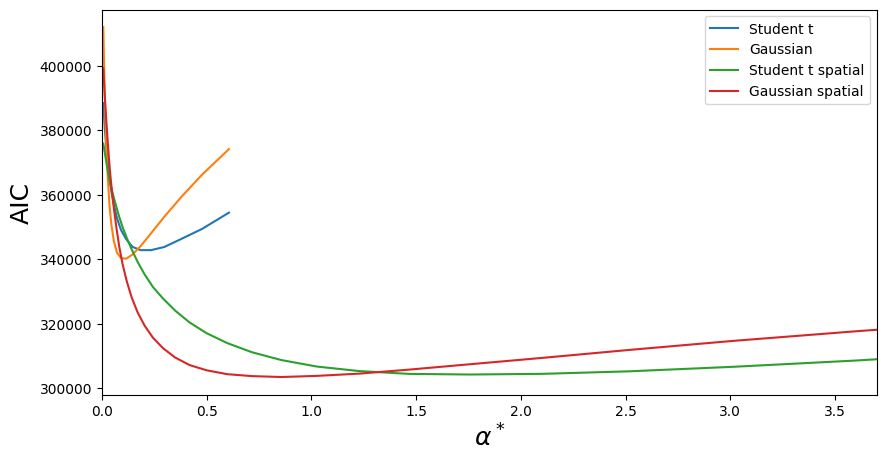

In [129]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(AQI_dict_t['alphas'], AIC_t[3], label = 'Student t')
ax.plot(AQI_dict_g['alphas'], AIC_g[3], label = 'Gaussian')
ax.plot(AQI_dict_t_spatial['alphas'], AIC_t_spat[0], label = 'Student t spatial')
ax.plot(AQI_dict_g_spatial['alphas'], AIC_g_spat[0], label = 'Gaussian spatial')
ax.legend()
ax.set_xlabel(r'$\alpha^*$', fontdict={'fontsize':18})
ax.set_ylabel(r'AIC', fontdict={'fontsize':18})
ax.set_xlim((0,3.7))

Plot example graphs

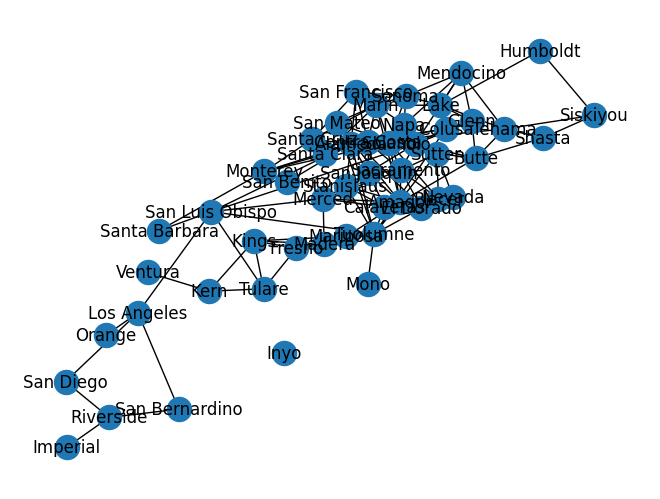

In [11]:
G1 = AQI_dict_t_spatial['thetas'][0][31][0].copy()
G1[np.abs(G1)<1e-2] = 0
np.fill_diagonal(G1,0)
G1  = nx.from_numpy_array(G1)
nx.draw(G1, labels={i:n for i,n in enumerate(ts_df.columns)}, with_labels = True, pos = pos_spatial)

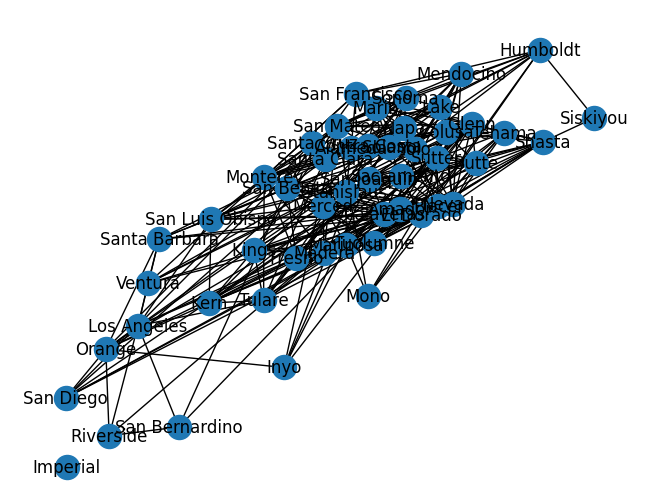

In [12]:
G2 = AQI_dict_t['thetas'][3][19][50].copy()
G2[np.abs(G2)<1e-3] = 0
np.fill_diagonal(G2,0)
G2  = nx.from_numpy_array(G2)
nx.draw(G2, labels={i:n for i,n in enumerate(ts_df.columns)}, with_labels = True, pos = pos_spatial)

Plot on California

In [131]:
dict_used = AQI_dict_g_spatial

In [152]:
AQI_dict_g_spatial['alphas'][25]

0.5988042596485019

In [132]:
import geopandas as gpd
shape_in = gpd.read_file('../../ca-county-boundaries/CA_Counties/CA_COUNTIES_TIGER2016.shp')
shape_in.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,42200,NaN,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,NaN,NaN,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,NaN,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [137]:
df_t.index = pd.to_datetime(df_t.index )

In [74]:
df_t.loc[(df_t.index <= datetime(2019,8,23)) & (df_t.index >= datetime(2019,7,23)) ].mean(axis = 0).values

array([ 54.625  ,  60.     ,  52.3125 ,  61.21875,  46.09375,  51.21875,
        69.25   , 101.15625,  42.21875,  23.3125 ,  73.46875,  59.625  ,
       108.3125 ,  75.34375,  32.6875 , 137.5    ,  71.9375 ,  31.25   ,
        76.9375 ,  30.65625,  69.96875,  26.71875,  36.5625 ,  36.03125,
        68.96875,  66.1875 ,  74.59375, 141.9375 ,  63.78125,  42.34375,
       173.9375 ,  89.34375,  33.125  ,  58.78125,  54.34375,  31.8125 ,
        50.4375 ,  53.21875,  28.375  ,  54.     ,  54.625  ,  48.28125,
        32.3125 ,  78.15625,  56.09375,  60.1875 , 116.90625,  68.28125,
        69.9375 ,  53.4375 ])

In [138]:
from datetime import datetime
values_aug_2019 = pd.DataFrame({'NAME':df_t.loc[(df_t.index <= datetime(2019,8,23)) & (df_t.index >= datetime(2019,7,23)) ].mean(axis = 0).keys(),
              'value':df_t.loc[(df_t.index <= datetime(2019,8,23)) & (df_t.index >= datetime(2019,7,23)) ].max(axis = 0).values} )

values_aug_2020 = pd.DataFrame({'NAME':df_t.loc[(df_t.index <= datetime(2020,8,23)) & (df_t.index >= datetime(2020,7,23)) ].mean(axis = 0).keys(),
              'value':df_t.loc[(df_t.index <= datetime(2020,8,23)) & (df_t.index >= datetime(2020,7,23)) ].max(axis = 0).values} )

In [139]:
shape_in_2019 = pd.merge(shape_in,values_aug_2019,  how = 'left', on = 'NAME')
shape_in_2019['value'].loc[np.isnan(shape_in_2019['value'])] = np.median(shape_in_2019['value'].loc[~np.isnan(shape_in_2019['value'])])

shape_in_2020 = pd.merge(shape_in, values_aug_2020, how = 'left', on = 'NAME')
shape_in_2020['value'].loc[np.isnan(shape_in_2020['value'])] = np.median(shape_in_2020['value'].loc[~np.isnan(shape_in_2020['value'])])

C:\Users\User\AppData\Local\Temp\ipykernel_22928\497159347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_in_2019['value'].loc[np.isnan(shape_in_2019['value'])] = np.median(shape_in_2019['value'].loc[~np.isnan(shape_in_2019['value'])])
C:\Users\User\AppData\Local\Temp\ipykernel_22928\497159347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_in_2020['value'].loc[np.isnan(shape_in_2020['value'])] = np.median(shape_in_2020['value'].loc[~np.isnan(shape_in_2020['value'])])


In [153]:
dict_used['thetas']

AttributeError: 'dict' object has no attribute 'shape'

In [154]:
coord_list_spatial= {i:[] for i in range(len(dict_used['thetas'][0][25]))}
node_pos_list = {i:[] for i in range(len(dict_used['thetas'][0][25]))}
for i in range(len(coord_list_spatial)):
    print(i)
    G_tmp = dict_used['thetas'][0][25][i].copy()
    G_tmp[np.abs(G_tmp)<1e-2] = 0
    np.fill_diagonal(G_tmp,0)
    G_tmp  = nx.from_numpy_array(G_tmp)

    for e in G_tmp.edges():
        
        n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[0]]]['geometry'].centroid
        n2 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[1]]]['geometry'].centroid
        coord_list_spatial[i].append(((n1.x.iloc[0], n1.y.iloc[0]), (n2.x.iloc[0], n2.y.iloc[0])))

    for node in G_tmp.nodes():
        n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[node]]['geometry'].centroid
        node_pos_list[i].append((n1.x.iloc[0], n1.y.iloc[0]))

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [155]:
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

C:\Users\User\AppData\Local\Temp\ipykernel_22928\1367260575.py:3: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


2019-08-23
2020-08-17


Text(0.5, 1.0, 'August 2020')

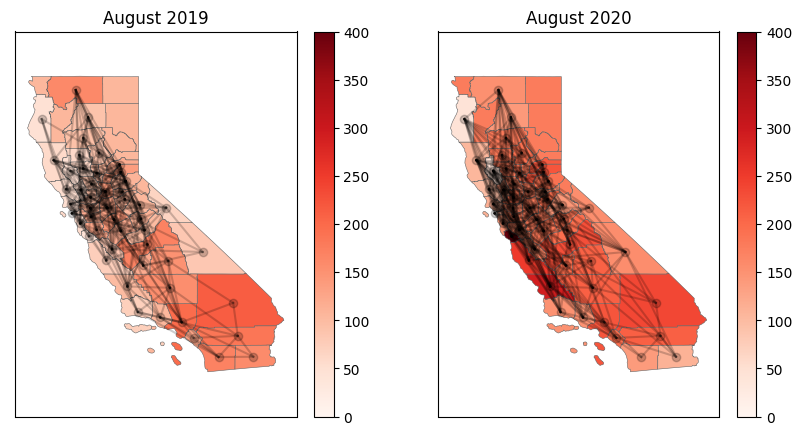

In [156]:


fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_aspect('equal', 'datalim')
axs[1].set_aspect('equal', 'datalim')
shape_in_2019.plot(ax = axs[0], column="value", cmap="Reds", linewidth=0.4, edgecolor=".4", legend=True, vmin = 0, vmax = 400)
shape_in_2020.plot(ax = axs[1], column="value", cmap="Reds", linewidth=0.4, edgecolor=".4", legend=True, vmin = 0, vmax = 400)



pos_1 = 62
pos_2 = 74
print(dict_used['index'][pos_1*30])
print(dict_used['index'][pos_2*30])

for i in range(len(coord_list_spatial[pos_1])):
    axs[0].plot((coord_list_spatial[pos_1][i][0][0], coord_list_spatial[pos_1][i][1][0]), (coord_list_spatial[pos_1][i][0][1], coord_list_spatial[pos_1][i][1][1]), color = "black", alpha = 0.2)
for i in range(len(node_pos_list[pos_1])):
    axs[0].scatter(node_pos_list[pos_1][i][0], node_pos_list[pos_1][i][1], color = "black", alpha = 0.2)

for i in range(len(coord_list_spatial[pos_2])):
    axs[1].plot((coord_list_spatial[pos_2][i][0][0], coord_list_spatial[pos_2][i][1][0]), (coord_list_spatial[pos_2][i][0][1], coord_list_spatial[pos_2][i][1][1]), color = "black", alpha = 0.2)
for i in range(len(node_pos_list[pos_2])):
    axs[1].scatter(node_pos_list[pos_2][i][0], node_pos_list[pos_2][i][1], color = "black", alpha = 0.2)


axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[0].set_title('August 2019')
axs[1].set_title('August 2020')

Plot number of changes and total size

In [34]:
import datetime
avg_temp = [62.3,61.2,63.7,64.9,70.5,69.0,75.2,75.3,76.5,72.9,66.0,59.1,
            62.0,64.1,68.2,65.8,64.2,70.6,73.7,77.1,78.7,75.6,62.6,57.1,
            57.7,64.9,63.2,66.6,65.0,71.3,75.1,73.6,73.7,70.0,65.7,58.6,
            57.1,59.8,65.5,67.8,67.1,71.4,76.4,76.6,75.2,74.1,66.4,61.0,
            62.2,59.4,60.1,64.4,64.9,70.1,78.8,78.3,73.4,70.5,65.1,58.9,
            57.9,54.0,61.1,65.2,63.3,69.3,74.4,75.5,76.6,72.2,64.9,59.4,
            60.9,62.6,61.3,66.6,70.5,71.3,72.2,76.7,76.2,73.0,62.8,60.0,
            59.0,60.5,59.5,64.6,66.3,71.1,74.9,74.4,71.3,66.6,64.0,54.5, 	
            58.5,58.8,61.4,64.3,64.8,71.0,72.4,75.2,77.5,68.7,60.2,57.5	
            ]


high_temp = [   85,82,90,92,102,81,92,91,103,98,90,83,
                85,88,93,92,84,91,92,97,101,100,87,83,
                77,90,87,89,78,101,97,91,104,95,93,82,
                80,80,88,90,94,94,98,102,102,104,93,83,
                86,84,78,95,90,88,108,98,92,90,88,77,
                78,69,69,87,77,92,95,85,97,97,92,77,
                83,88,82,93,95,98,92,98,111,101,91,84,
                88,82,88,90,85,90,90,92,94,93,90,73,
                78,86,85,95,89,90,93,92,103,93,79,84]

temp_dates =  []
for year in range(2014,2022+1):
    for m in range(1,13):
        temp_dates.append(datetime.datetime(year,m,15))

temp_dates = np.array(temp_dates)
avg_temp = np.array(avg_temp)
high_temp = np.array(high_temp)

In [184]:
def get_nr_changes(x,y,tol = 1e-2):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A)>1e-1)

def get_change_size(x,y):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A))

def get_positive_change_size(x,y):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A[A>0]))

def get_negative_change_size(x,y):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(A[A<0])

    
nr_changes = []
change_sizes = []
positive_change_sizes = []
negative_change_sizes = []
thetas = dict_used['thetas'][7][31].copy()
thetas[np.abs(thetas)<1e-2] = 0
for i in range(len(dict_used['thetas'][0][0])-1):
    A1 = thetas[i].copy()
    A2 = thetas[i+1].copy()

    nr_changes.append(get_nr_changes(A2,A1))
    change_sizes.append(get_change_size(A2,A1))
    positive_change_sizes.append(get_positive_change_size(A2,A1))
    negative_change_sizes.append(get_negative_change_size(A2,A1))

variance = []
nr_edges = []

for i in range(len(dict_used['thetas'][0][0])):
    A1 = thetas[i].copy()
    d = A1.shape[0]
    variance.append(np.dot(np.ones(d), np.linalg.inv(A1)).dot(np.ones(d)))
    nr_edges.append(np.sum(A1[np.triu_indices(d, 1)] != 0))


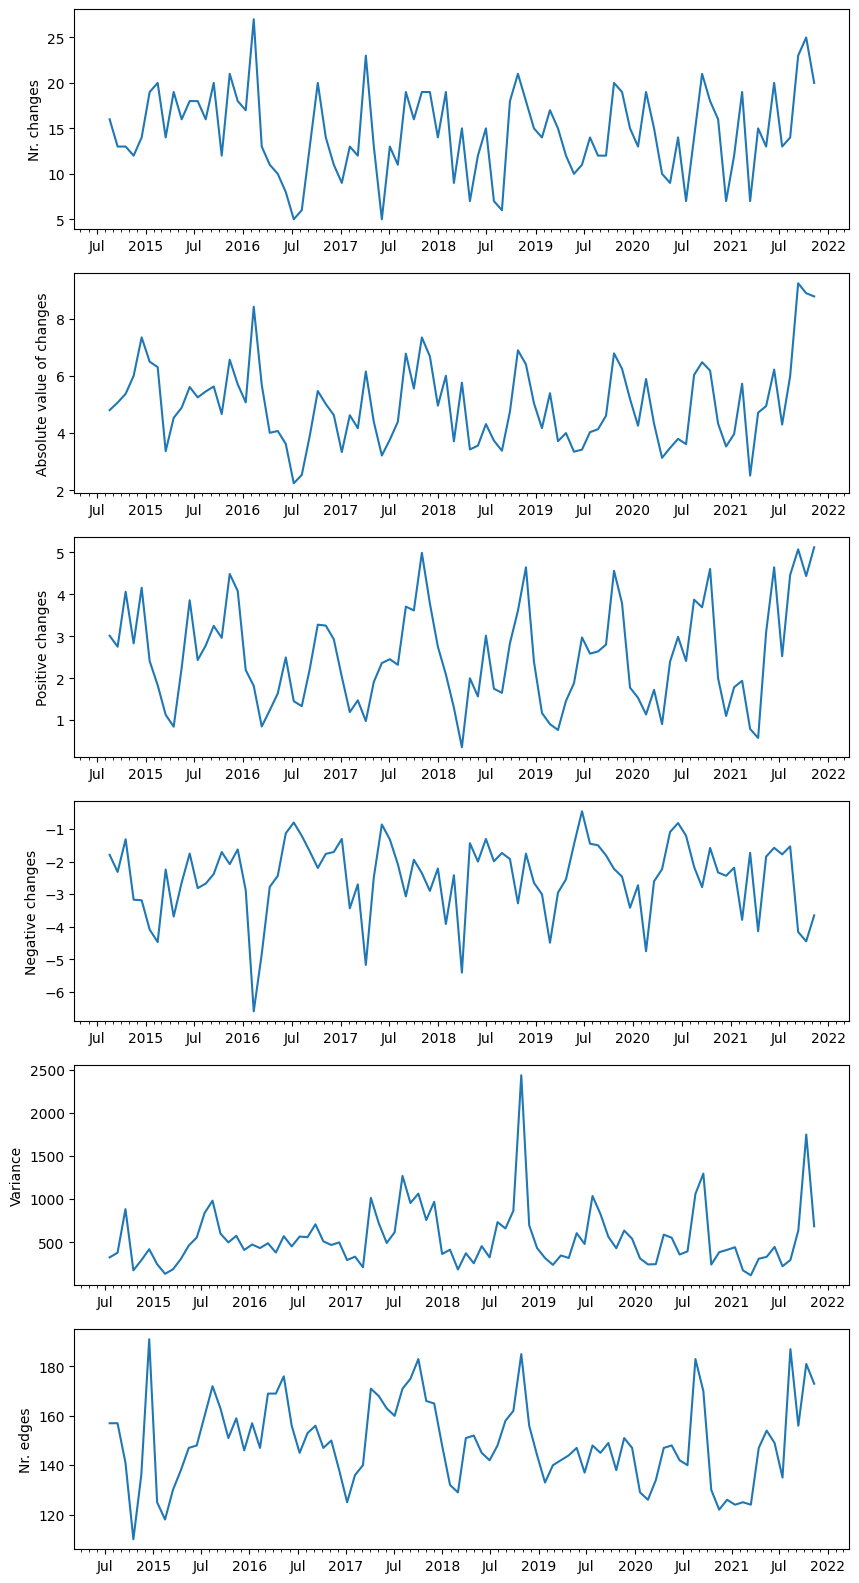

In [185]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

fig, axs = plt.subplots(6,1, figsize = (10,20))
axs[0].plot(pd.to_datetime(AQI_dict_t_spatial['index'][30::30]), nr_changes)
axs[0].set_ylabel("Nr. changes")

axs[1].plot(pd.to_datetime(dict_used['index'][30::30]), change_sizes)
axs[1].set_ylabel("Absolute value of changes")

axs[2].plot(pd.to_datetime(dict_used['index'][30::30]), positive_change_sizes)
axs[2].set_ylabel("Positive changes")

axs[3].plot(pd.to_datetime(dict_used['index'][30::30]), negative_change_sizes)
axs[3].set_ylabel("Negative changes")

axs[4].plot(pd.to_datetime(dict_used['index'][::30]), variance)
axs[4].set_ylabel("Variance")

axs[5].plot(pd.to_datetime(dict_used['index'][::30]), nr_edges)
axs[5].set_ylabel("Nr. edges")

for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # ax.grid(True)
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))



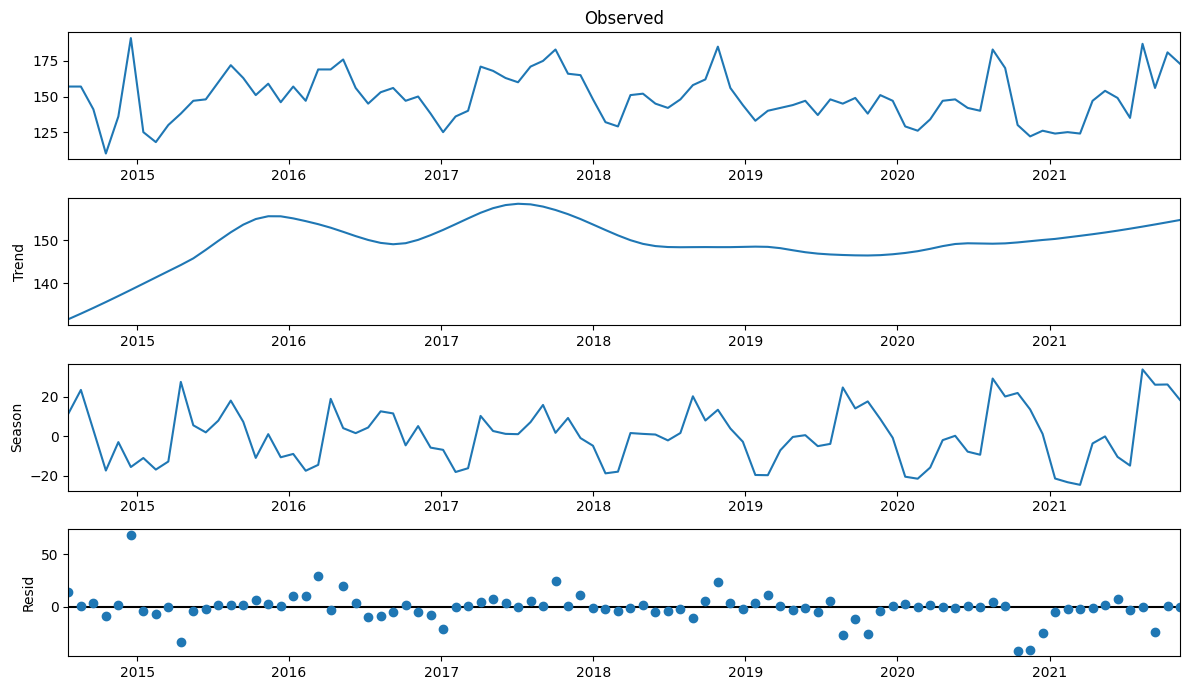

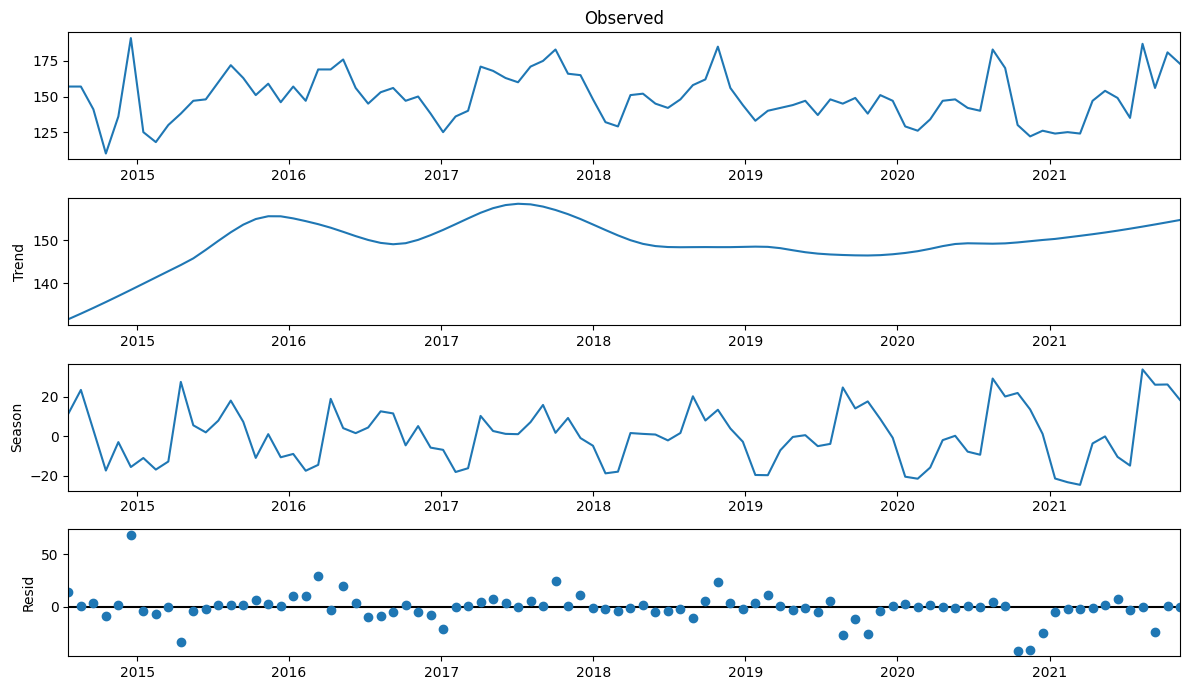

In [186]:
from statsmodels.tsa.seasonal import STL
plt.rc('figure',figsize=(12,7))
stl = STL(pd.DataFrame(nr_edges, index = pd.to_datetime(dict_used['index'][::30])), seasonal=21, period = 12, robust = True)
res = stl.fit()

res.plot()


In [77]:
HDD = pd.read_csv("../data/AQI/HDD.csv")
HDD.head()

,year,Observed,CanESM2 (Average),CNRM-CM5 (Cool/Wet),HadGEM2-ES (Warm/Dry),MIROC5 (Complement)
0,1950,1265.018799,NaN,NaN,NaN,NaN
1,1951,1112.774780,NaN,NaN,NaN,NaN
2,1952,1236.863892,NaN,NaN,NaN,NaN
3,1953,1038.377808,NaN,NaN,NaN,NaN
4,1954,976.274902,NaN,NaN,NaN,NaN


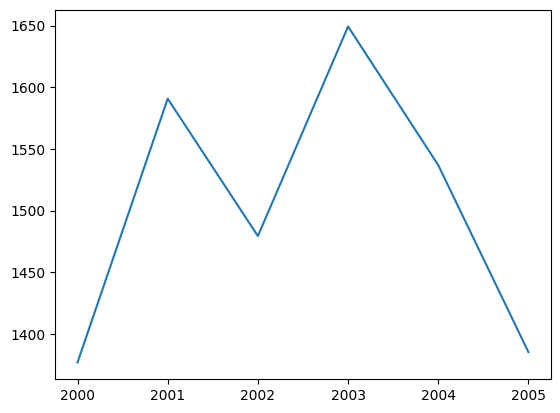

In [79]:
plt.plot(HDD['year'].iloc[50:], HDD['Observed'].iloc[50:])